In [100]:
import torch as th
from matplotlib import animation
import numpy as np
import seaborn as sns
import data as data_lib
import evaluation
import re_eval
import os 
import matplotlib.pyplot as plt

In [12]:
models = re_eval.load_all_important_models()
models = {k: v for k, v in models.items() if '2d' in k and 'mammal' in k}

In [13]:
name, model = models.popitem()
print(name)

..\model\data\new_1\mammals.normal.2d.lr=2.0.dim=2.negs=50.burnin=10.batch=10


In [14]:
maxn = model.log.get_eval_result().epoch.max()

In [15]:
from collections import Counter
def filter_idx(_idx):
    count = Counter()
    for i, j, _ in _idx:
        count[i] += 1
        count[j] += 1
        
    ret = []
    head = Counter()
    tail = Counter()
    N = 20
    for i, j, _ in _idx:
        if count[i] < N or count[j] < N:
            continue
        if head[i]:
            continue
        ret.append((i, j, _))
        head[i] += 1
        tail[j] += 1
    return ret


In [113]:
def plot(_model, epoch, data_path, plot_words=True, filter_seg=True, plot_binary=False):
    fin = os.path.join(_model.path_to_dir, '%d.nth' % (epoch, ))
    with open(fin, 'rb') as f:
        data = th.load(f)
    
    emb = data['model']['lt.weight']
    objs = data['objects']
    idx, _, _ = data_lib.slurp(data_path, objects=objs)
    if filter_seg:
        idx = filter_idx(idx)
    emb = emb[:node_num].numpy()
    objs = objs[:node_num]
    if plot_binary:
        temp = emb[0].copy()
        emb[0] = emb[1]
        emb[1] = temp
        idx[1][1] = 0
        idx[2][1] = 1
        idx[3][1] = 1
        idx = idx[:30]
        emb = th.from_numpy(emb)
        s = [800, 400, 400] + [200] * 4 + [100]*8 + [50]*16 + [10] * node_num
    else:
        s = 5
        
    import random
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.axis('off')
    ax.scatter(emb[:, 0], 
               emb[:, 1],
               alpha=0.3,
               s=s)
    already_there = []
    segs = []
    for h, t, _ in idx:
        if filter_seg and (h >= node_num or t >= node_num):
            continue
            
        rh = th.sqrt(th.sum(emb[h]**2))
        rt = th.sqrt(th.sum(emb[t]**2))
        di = th.sqrt(th.sum((emb[t] - emb[h])**2))
        segs.append((emb[h].tolist(), emb[t].tolist()))
    
    if plot_words:
        for i in range(len(objs)):
            r = th.sqrt(th.sum(emb[i]**2))
            if epoch != maxn or r > 0.9:
                if random.random() > np.exp(-3 * r):
                    continue

                too_close = False
                for i, node in enumerate(already_there):
                    dis = th.sqrt(th.sum((emb[i] - node)**2))
                    if dis < 0.3:
                        too_close = True
                        break

                if too_close:
                    continue

            already_there.append(emb[i])
            ax.annotate(objs[i], xy=(emb[i][0], emb[i][1]),  xycoords='data',
                    xytext=(emb[i][0], emb[i][1]), textcoords='offset points',
                    bbox=dict(boxstyle="round4,pad=.5", fc="0.9"),)

    ln_coll = matplotlib.collections.LineCollection(segs, linewidths=0.5)
    ax.add_collection(ln_coll)
    ax.set_xlim(-1, 1)    
    ax.set_ylim(-1, 1)
    plt.draw()
    return fig
    


In [ ]:

import matplotlib
node_num = 300000

print(maxn)
for epoch in (9, 19, maxn):
    plot(model, epoch, './wordnet/mammal_closure.tsv')

In [85]:
model = re_eval.ModelInfo('./model/binaryTree.2d_imb.lr=2.0.dim=2.negs=50.burnin=10.batch=10')

In [78]:
maxn = model.log.get_eval_result().epoch.max()
print(maxn)

1299


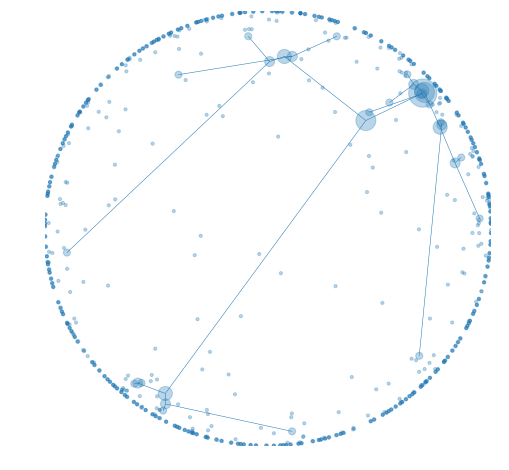

In [114]:
fig = plot(model, 1299, './wordnet/binaryTree.tsv', False, False, True)

C:\Users\Administrator\Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


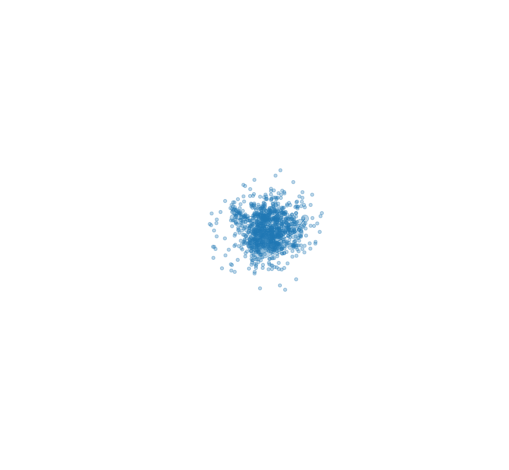

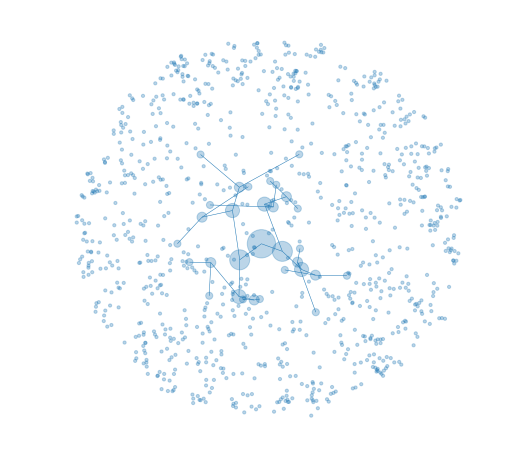

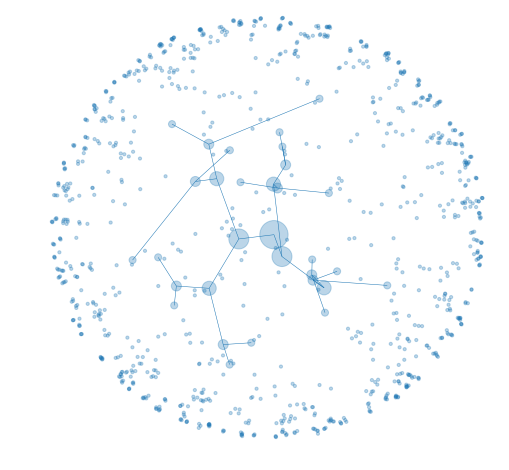

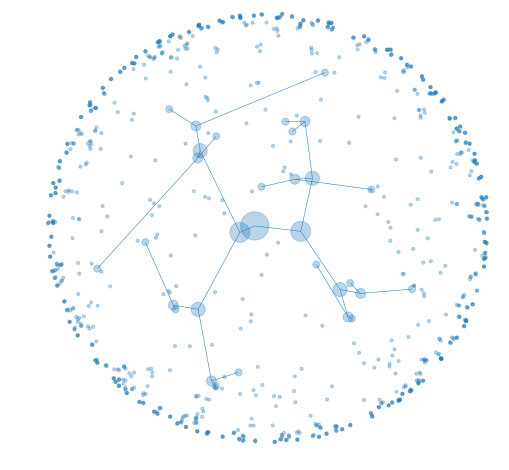

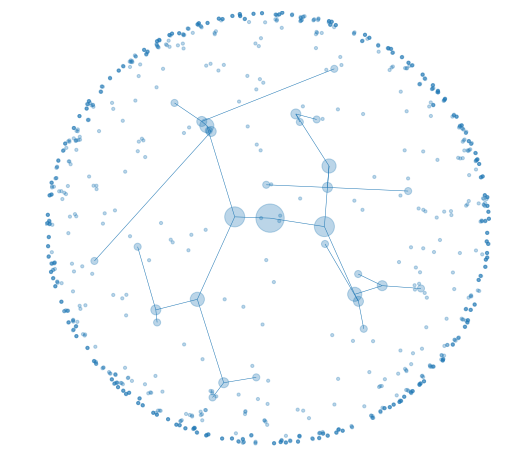

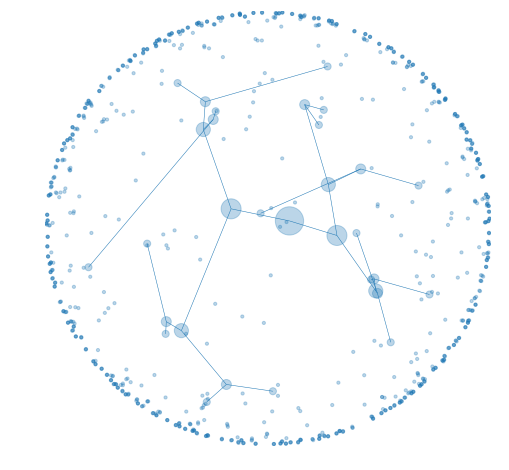

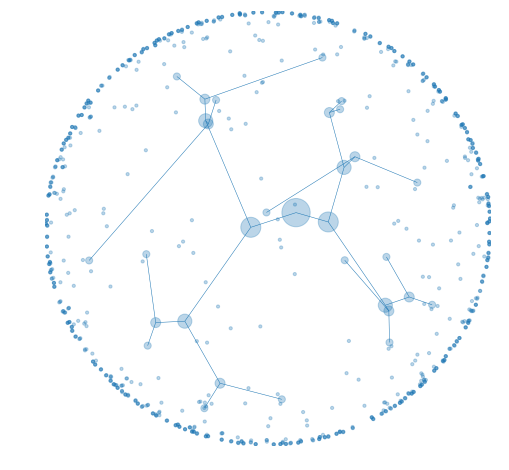

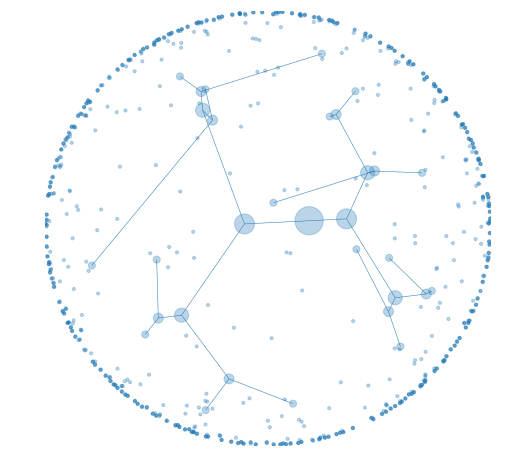

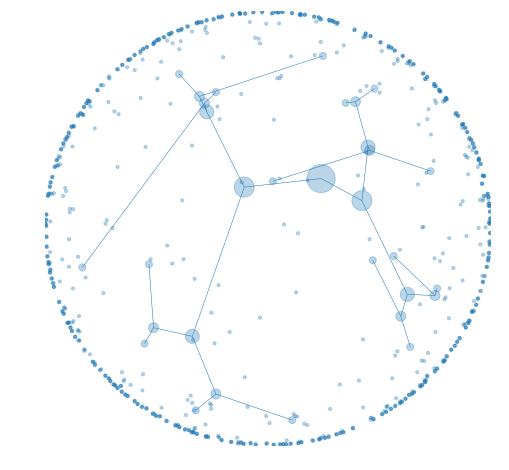

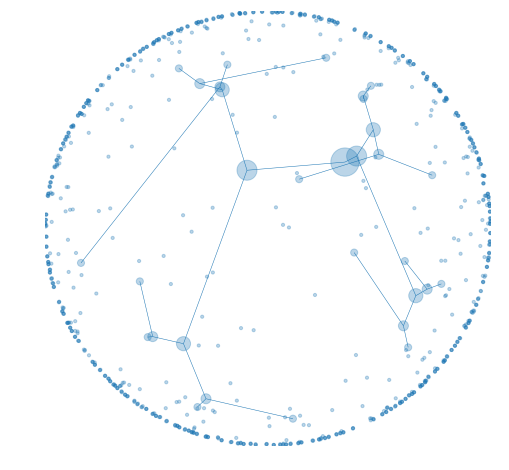

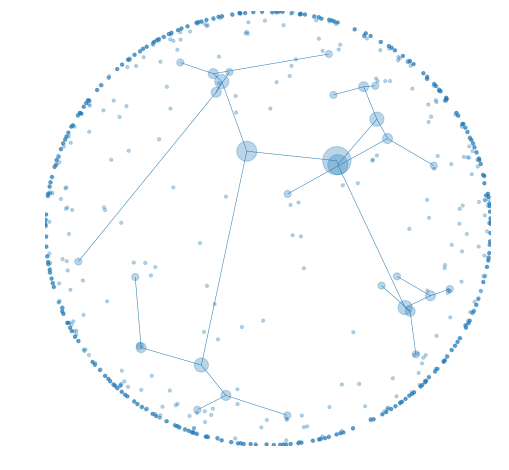

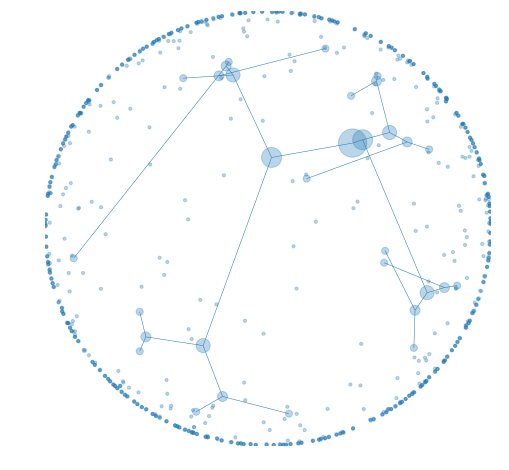

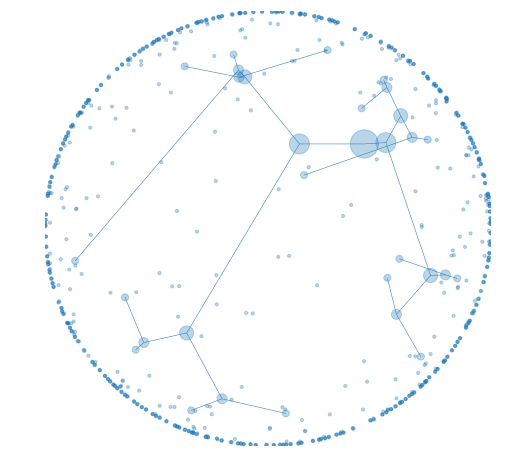

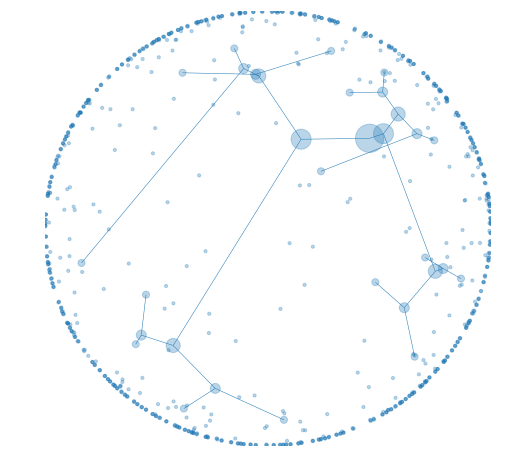

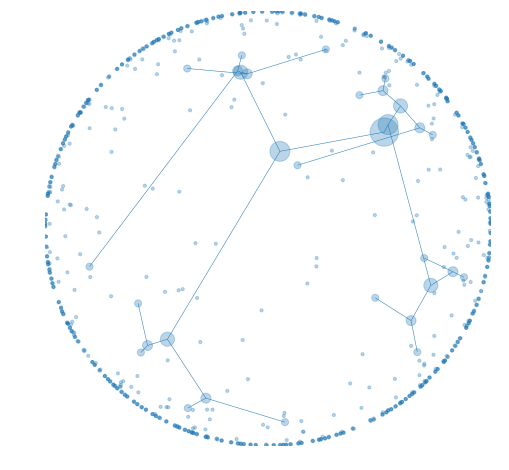

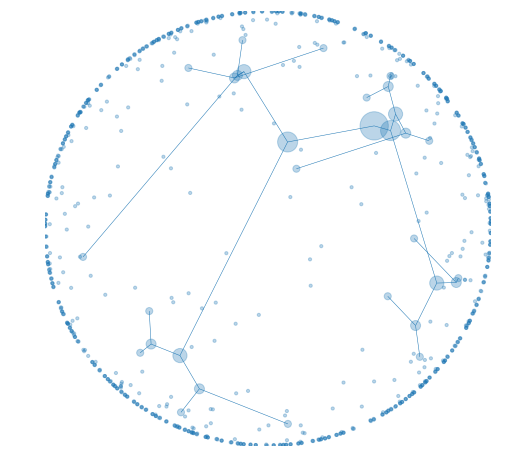

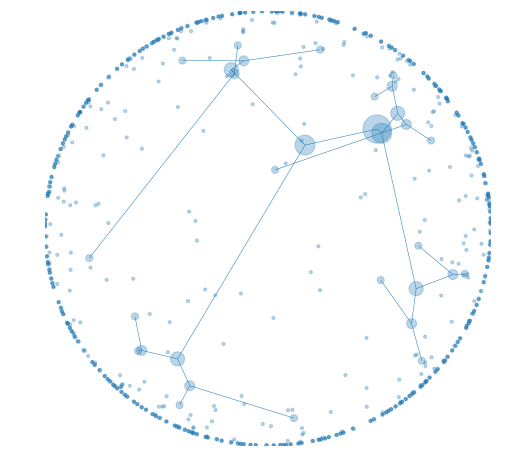

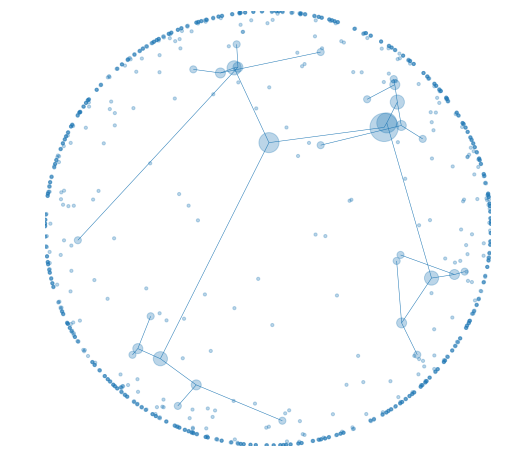

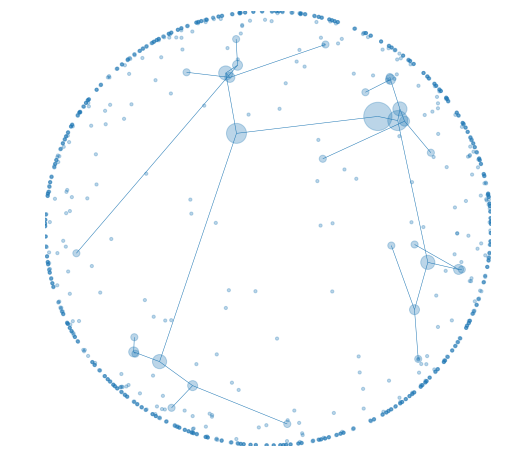

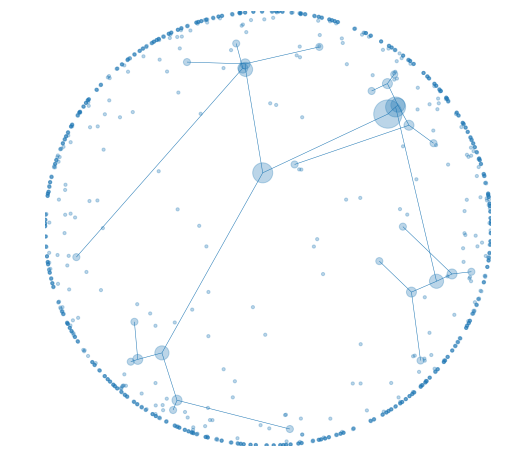

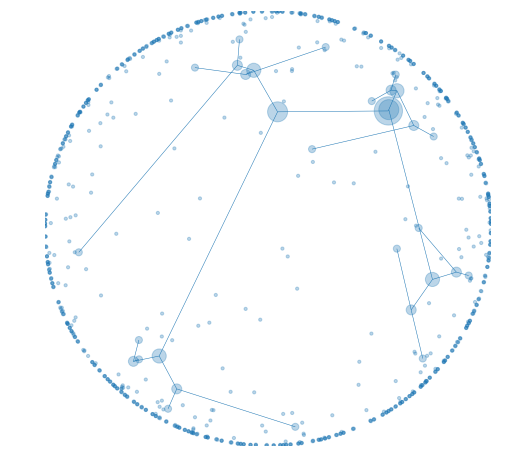

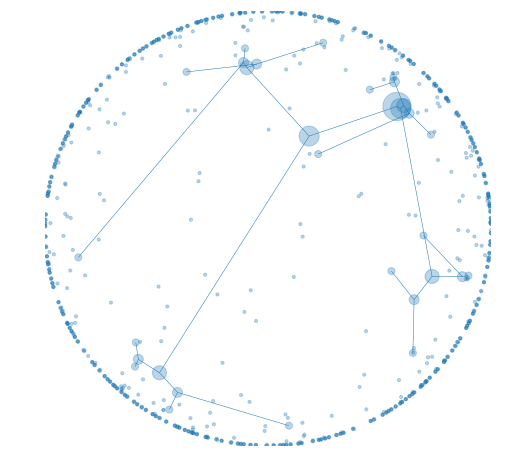

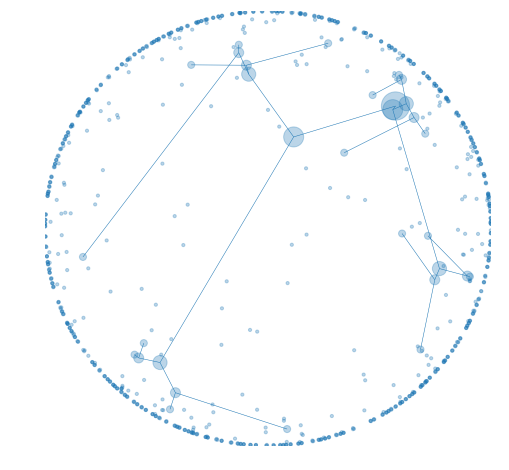

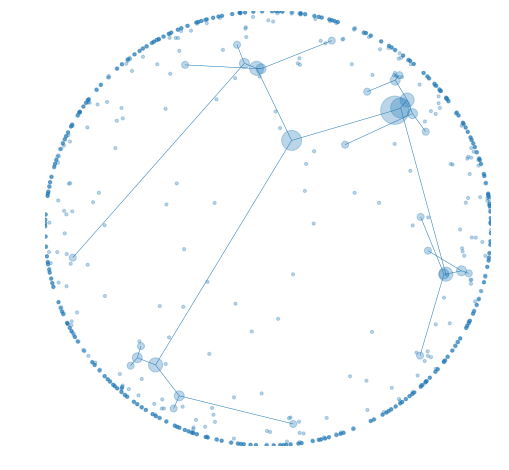

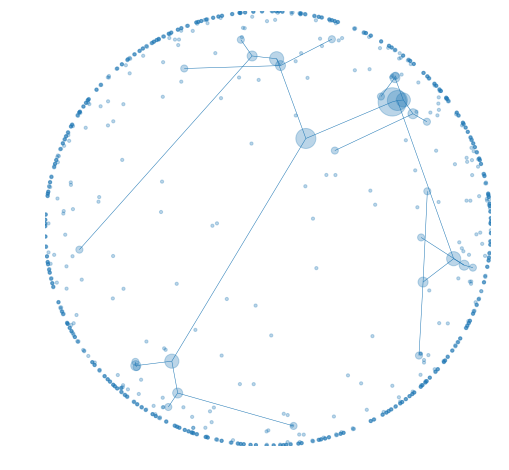

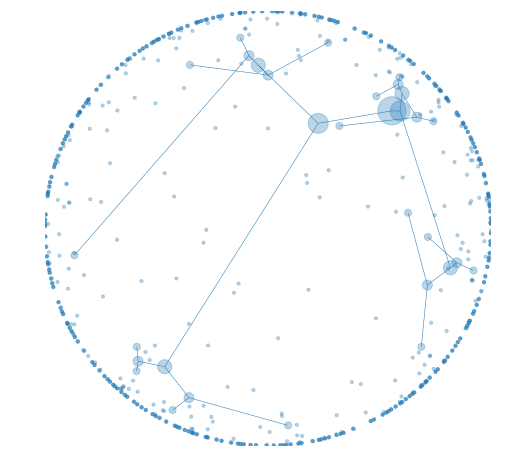

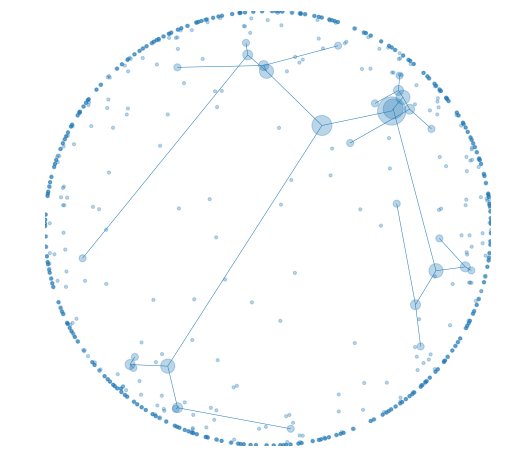

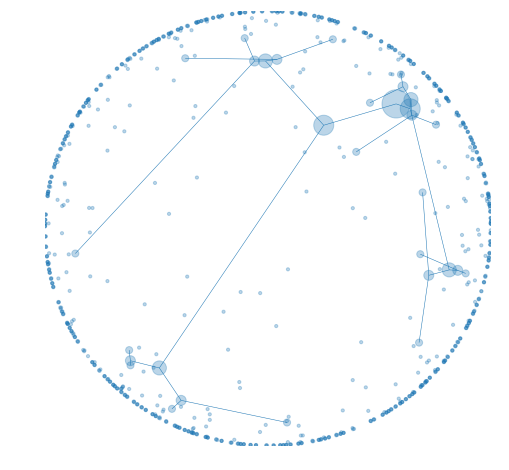

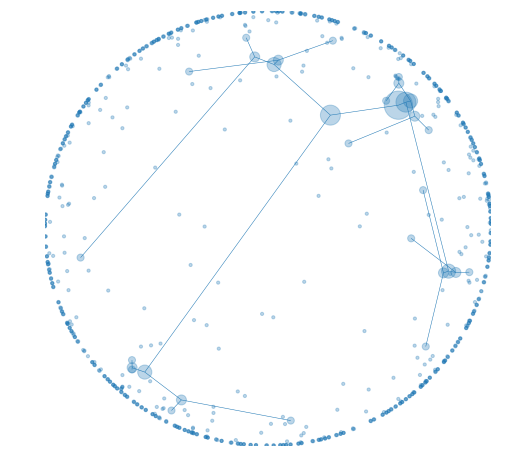

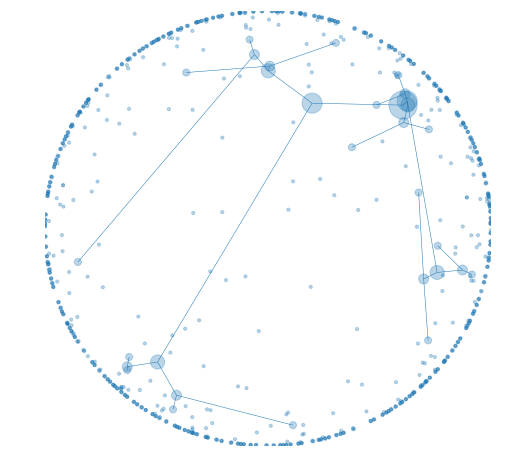

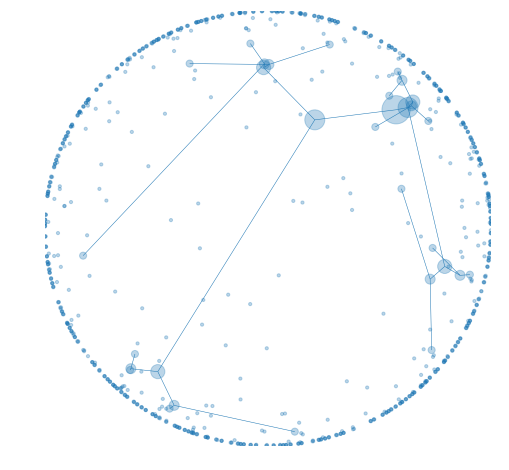

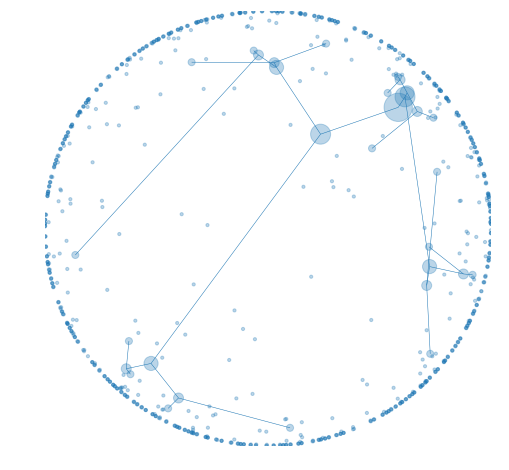

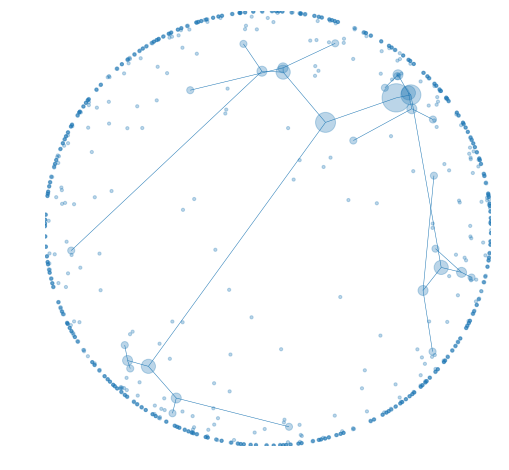

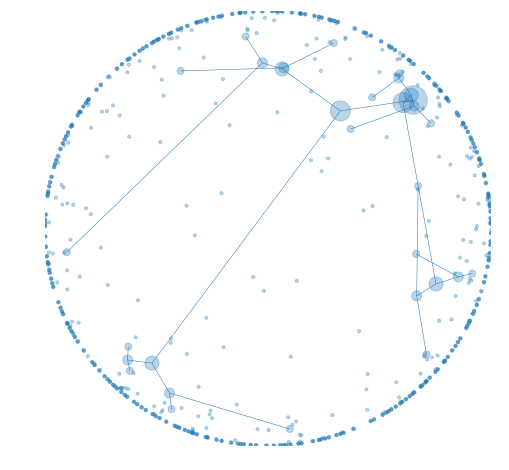

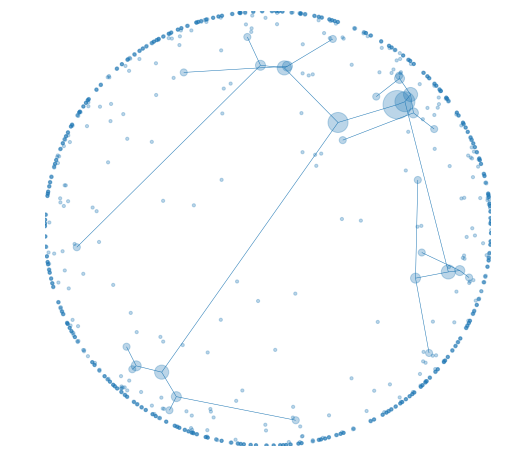

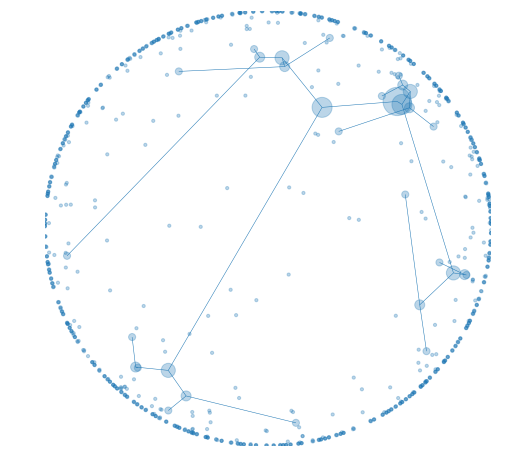

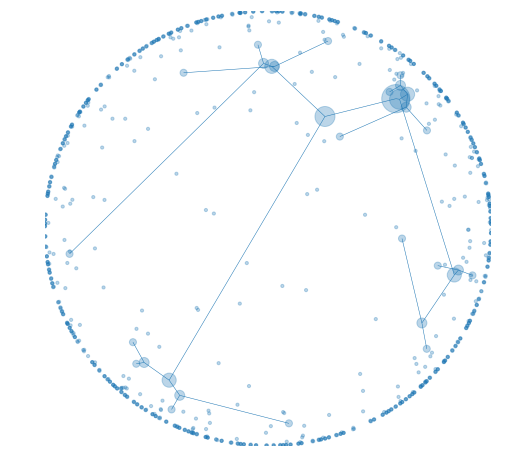

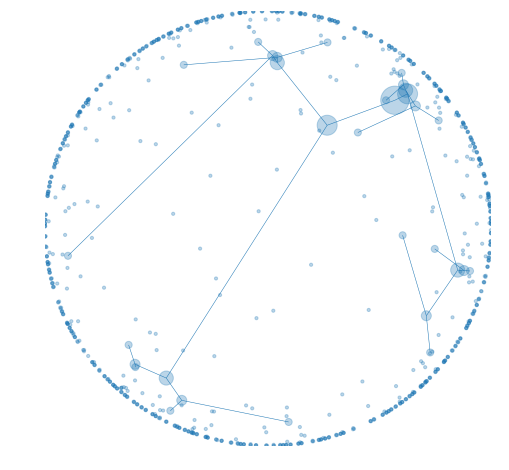

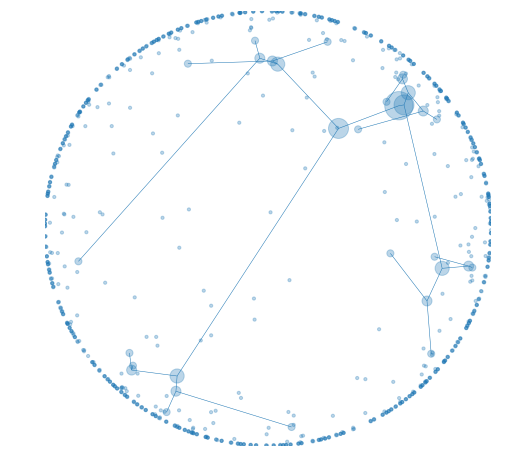

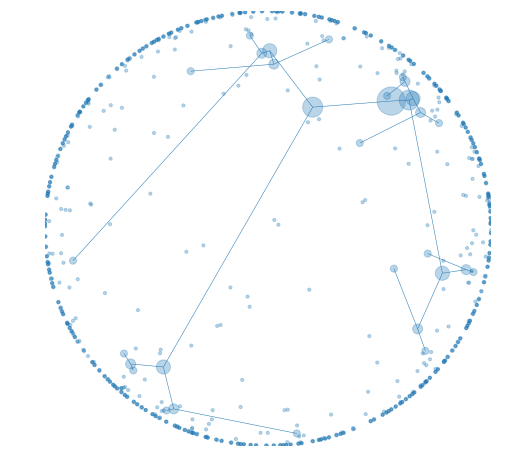

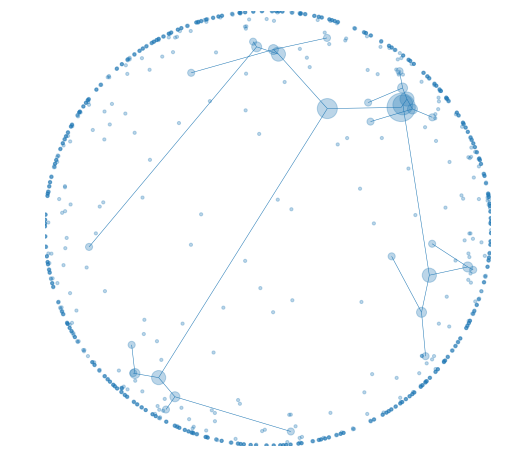

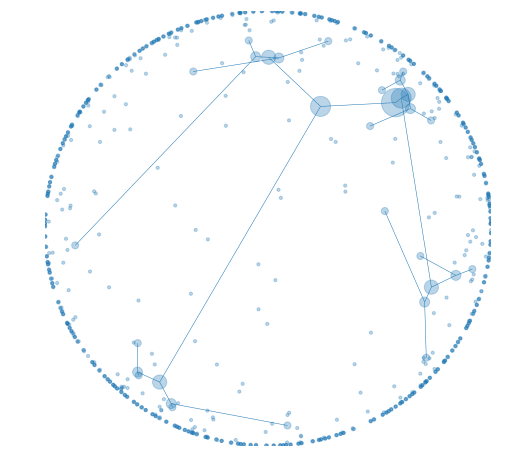

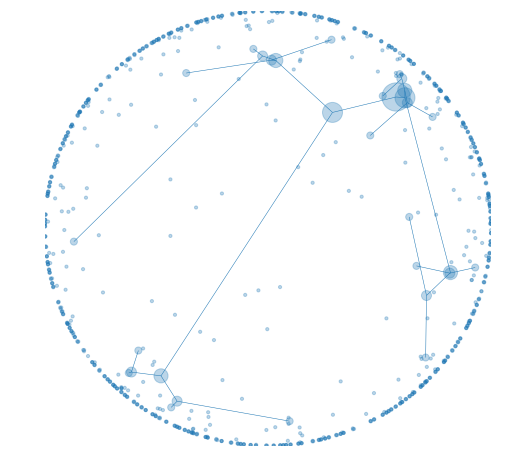

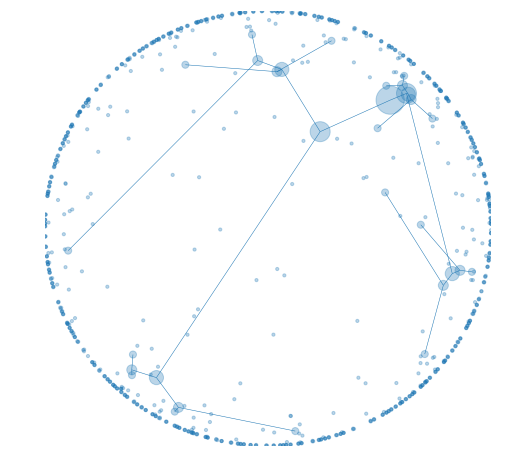

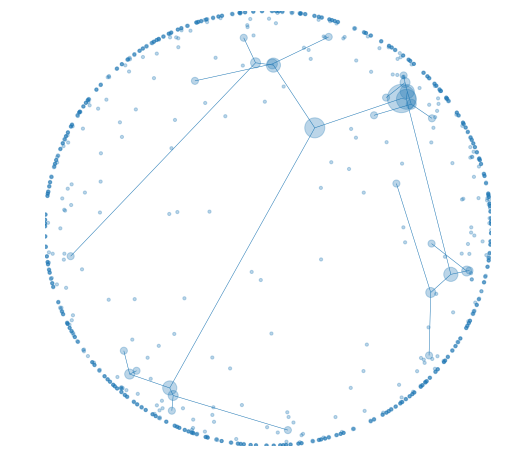

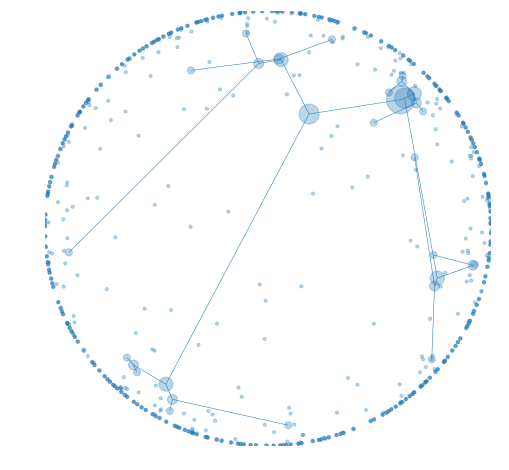

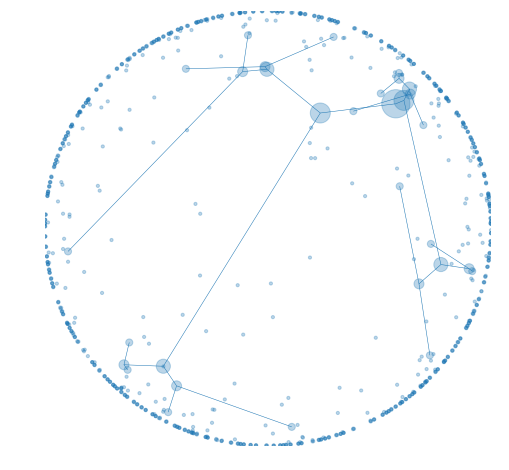

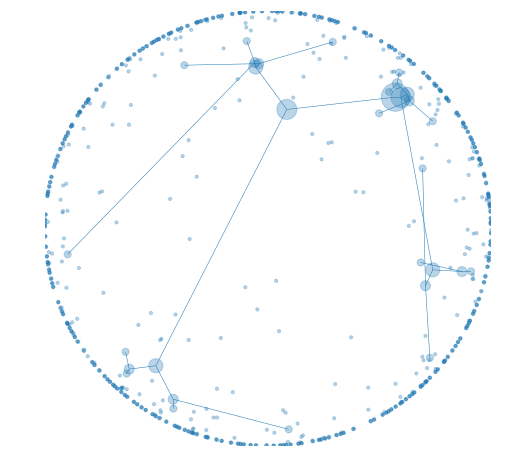

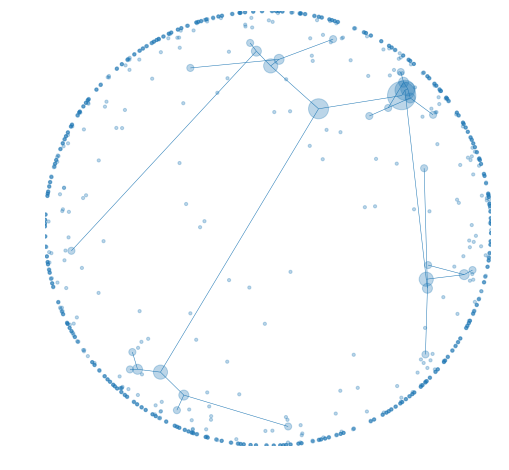

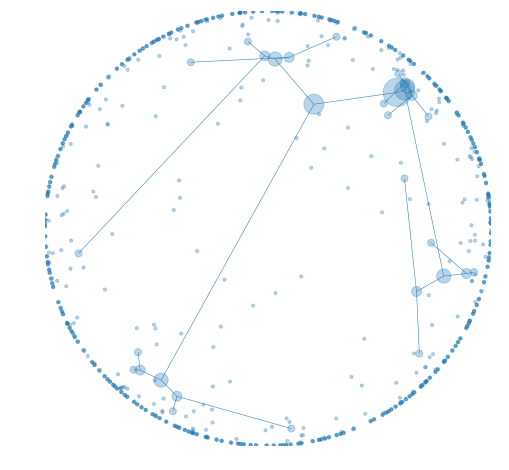

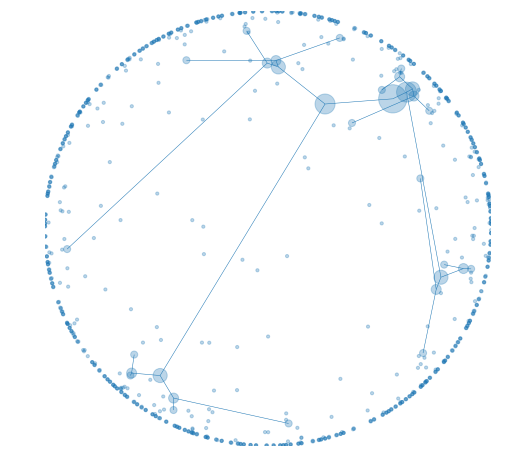

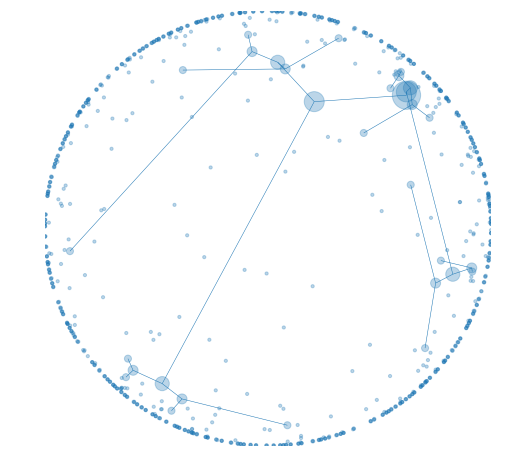

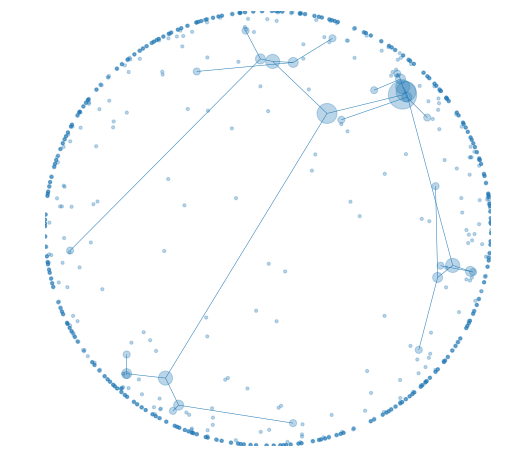

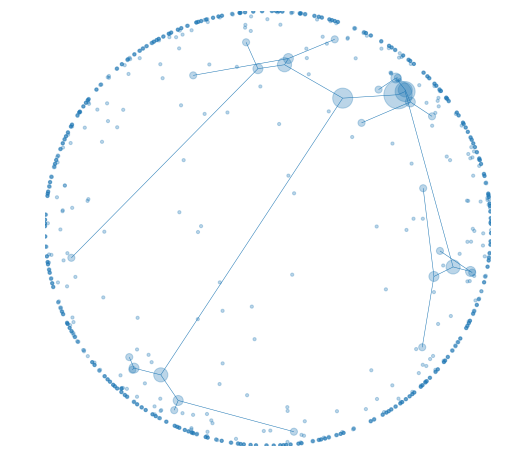

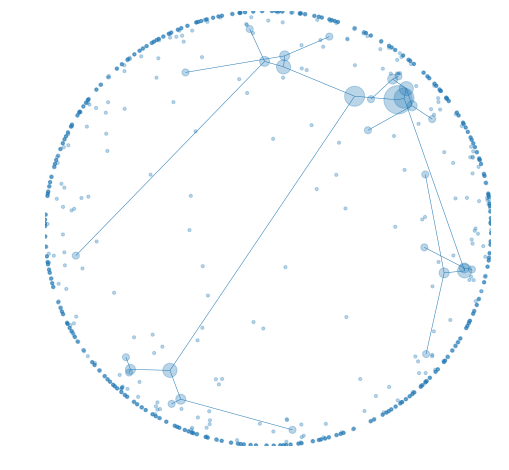

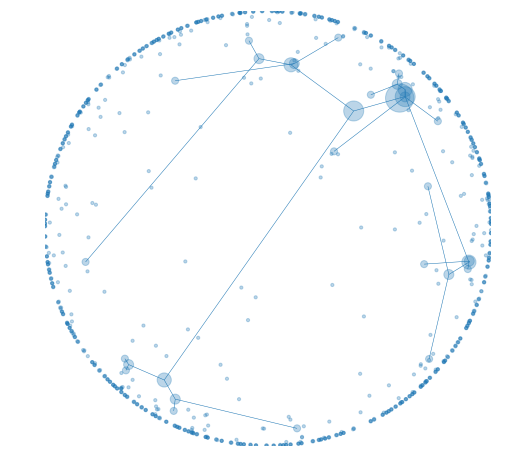

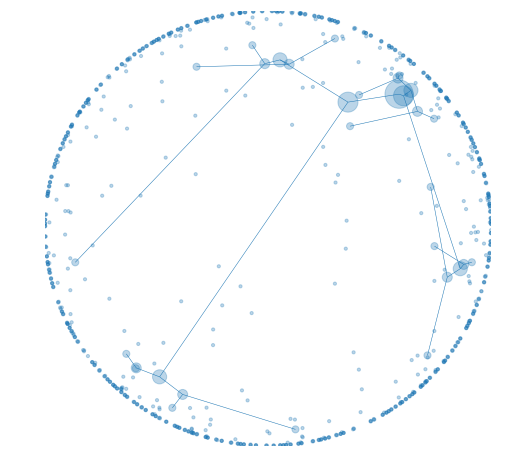

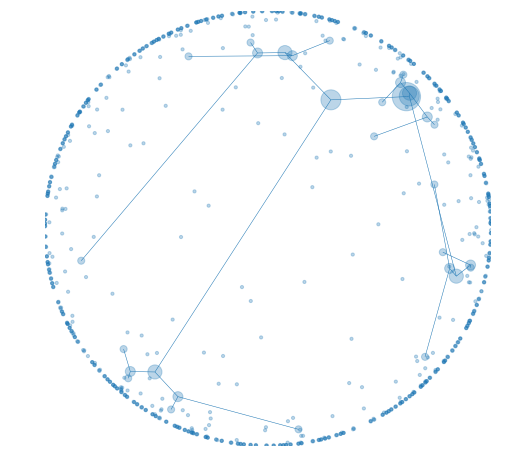

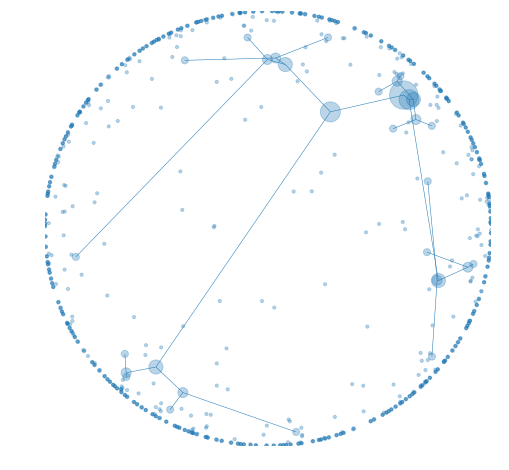

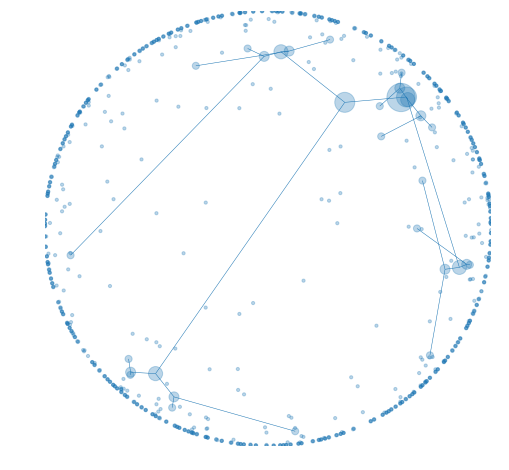

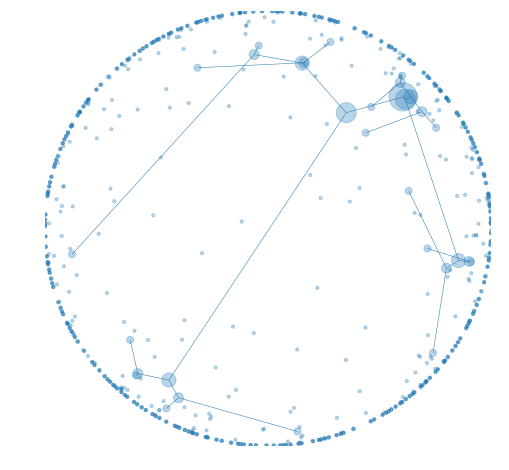

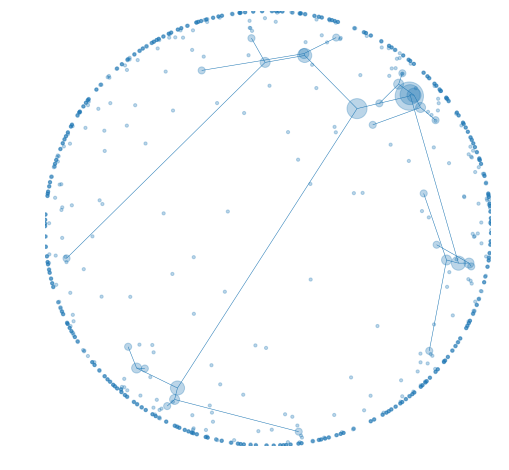

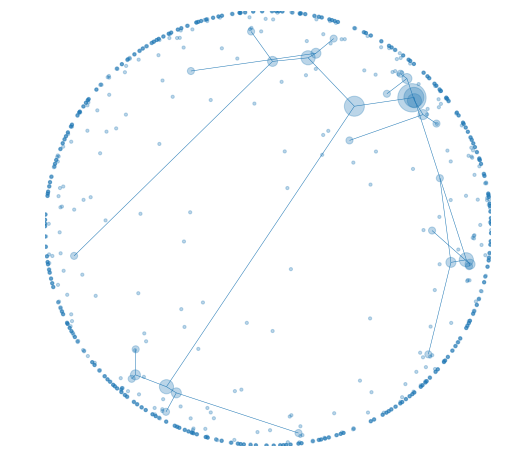

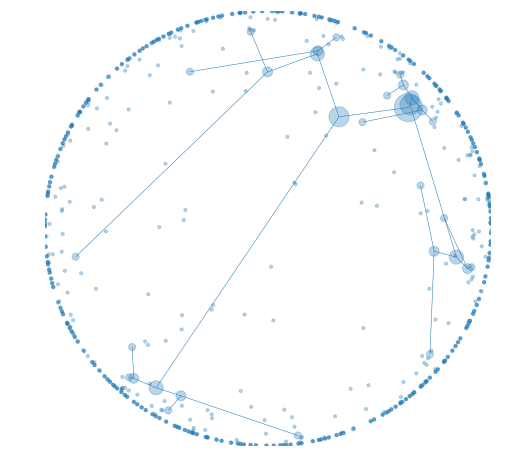

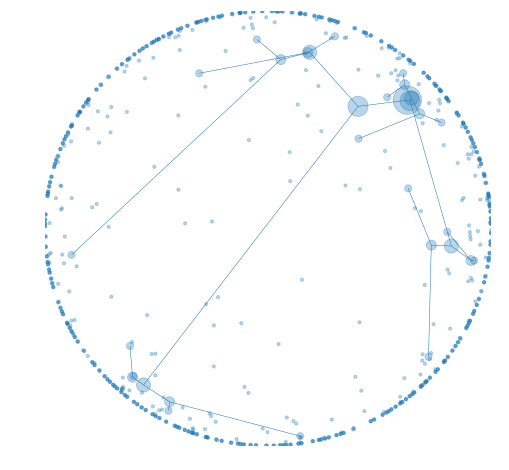

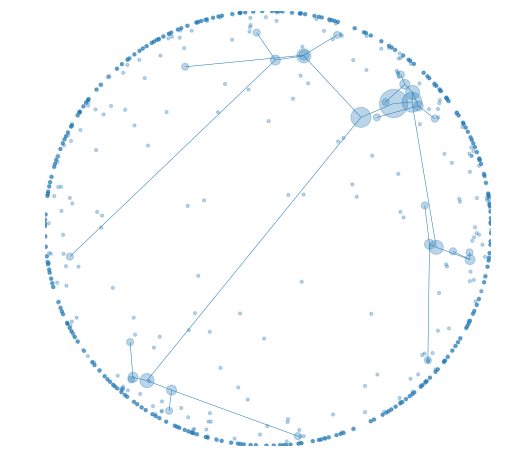

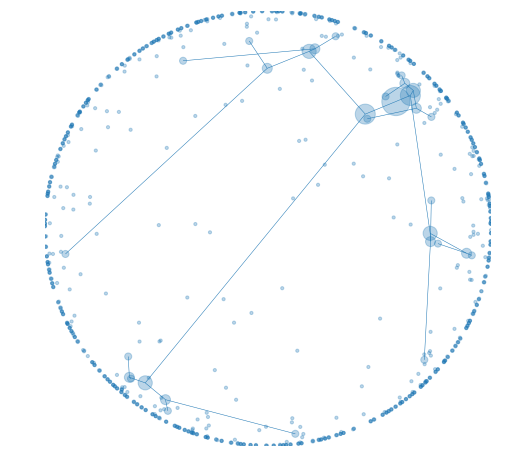

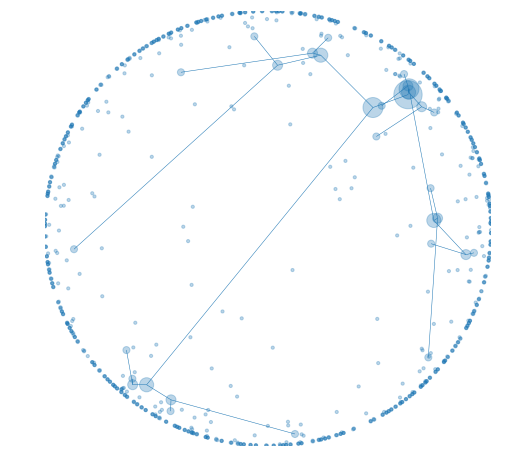

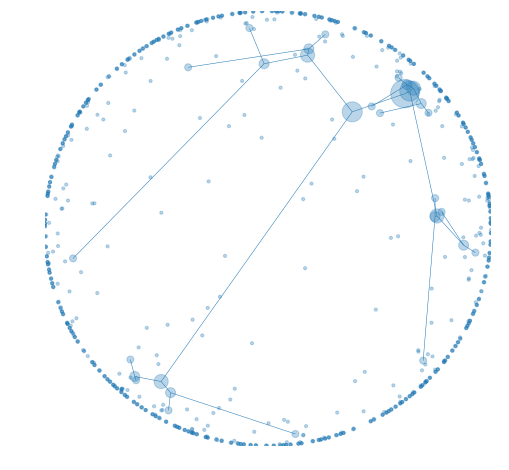

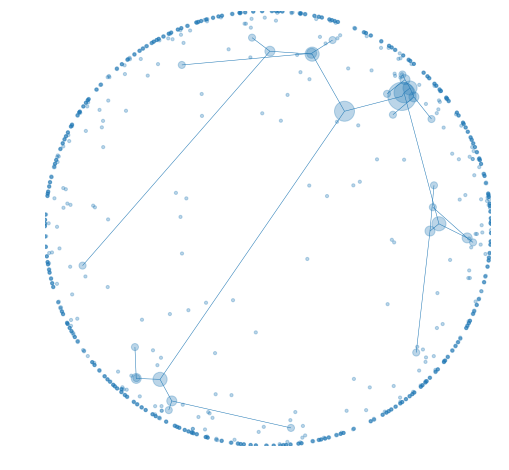

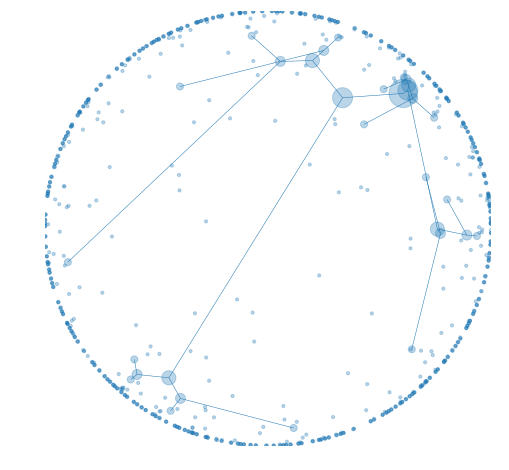

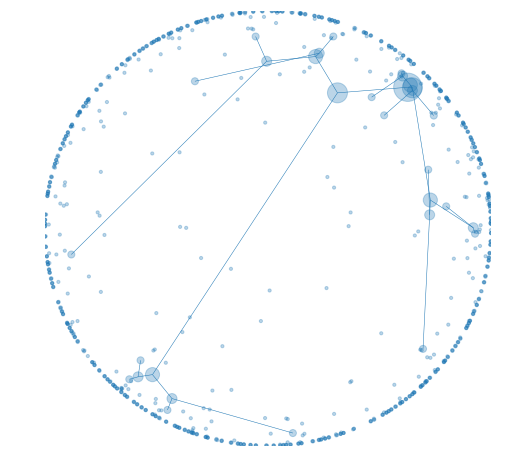

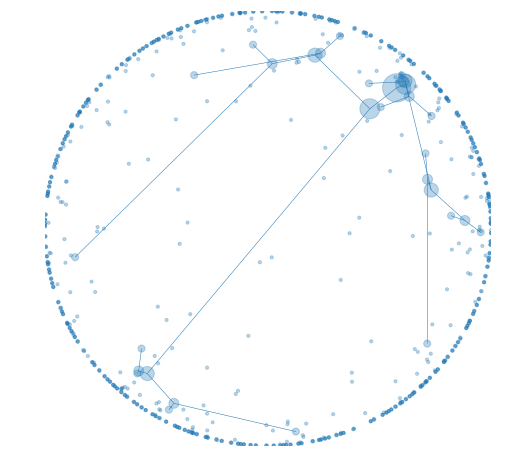

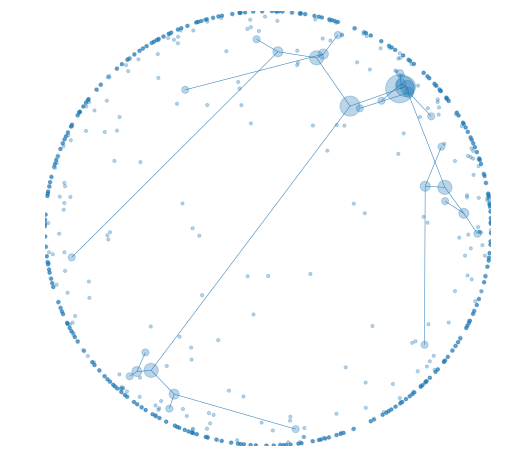

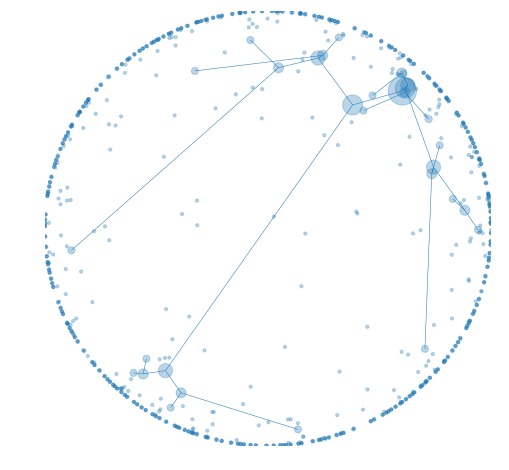

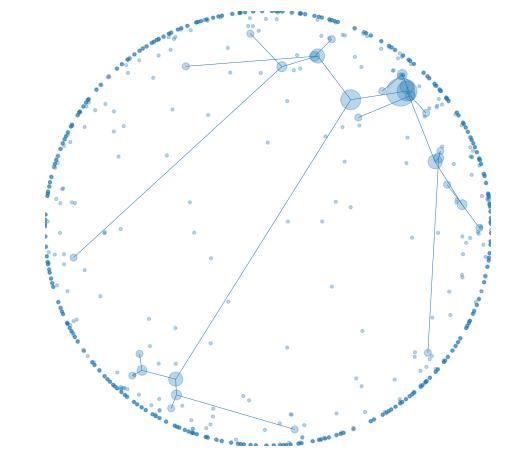

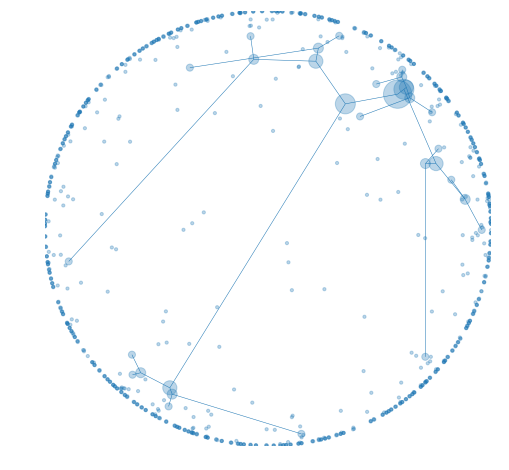

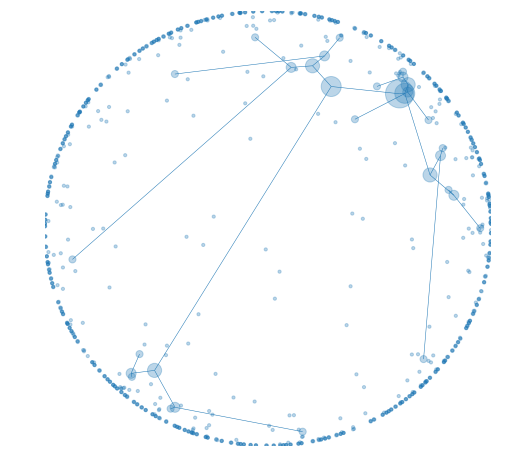

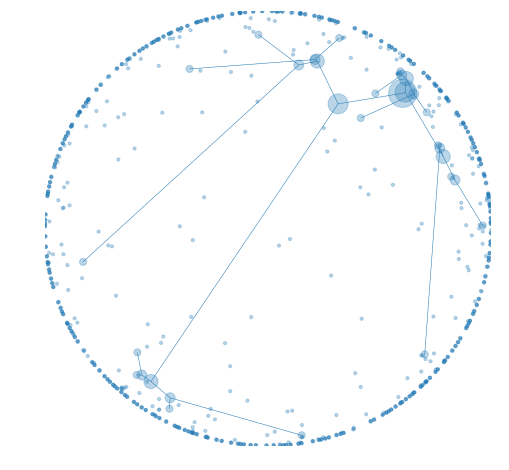

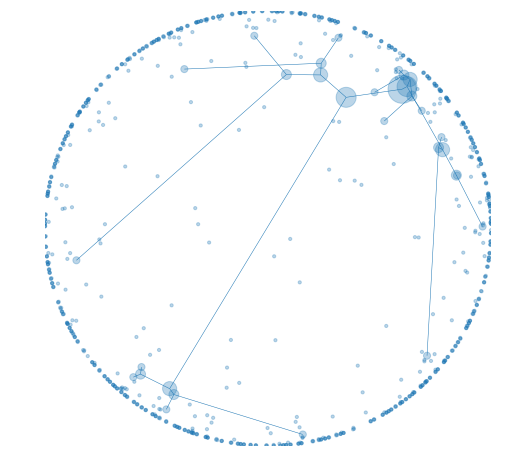

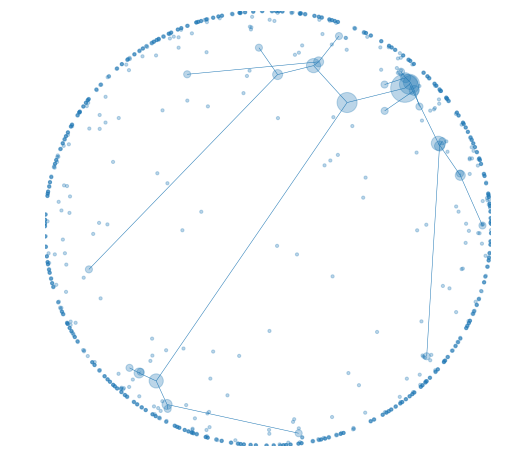

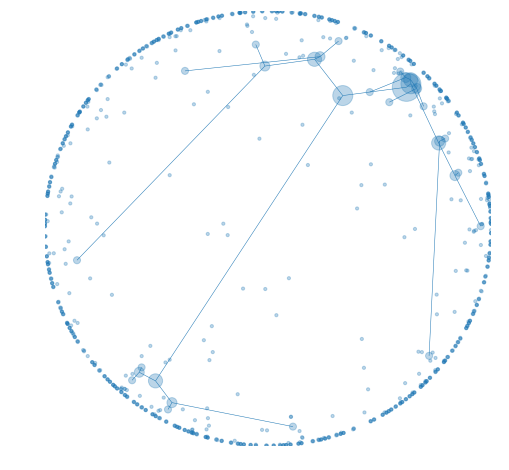

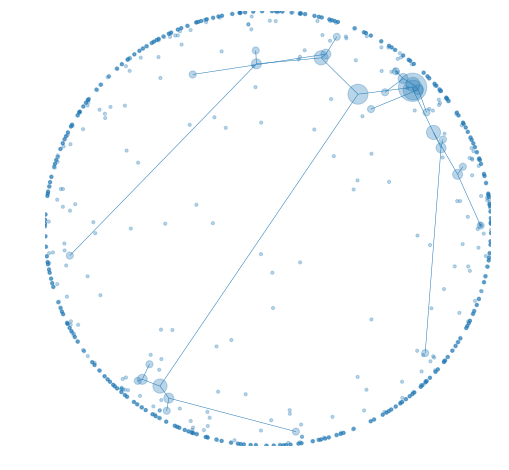

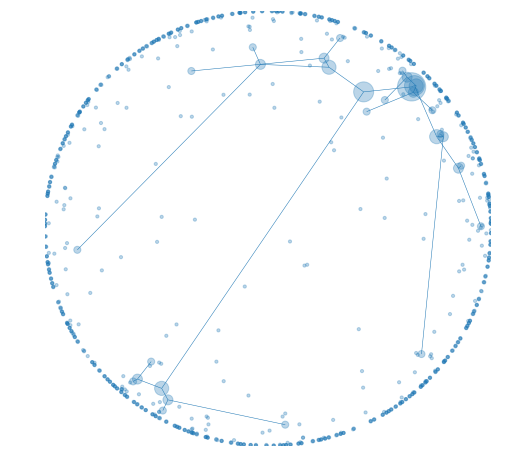

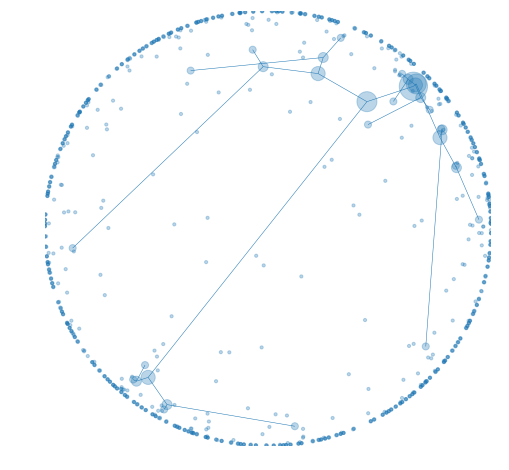

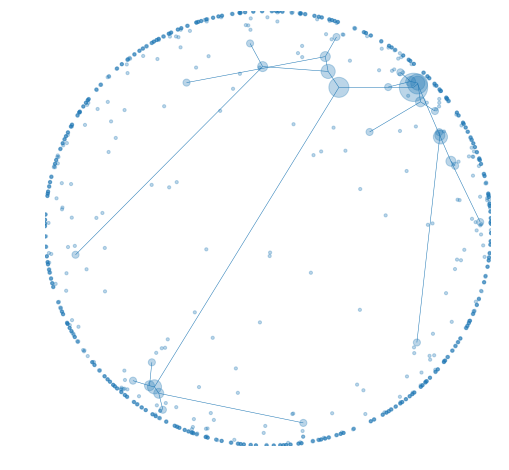

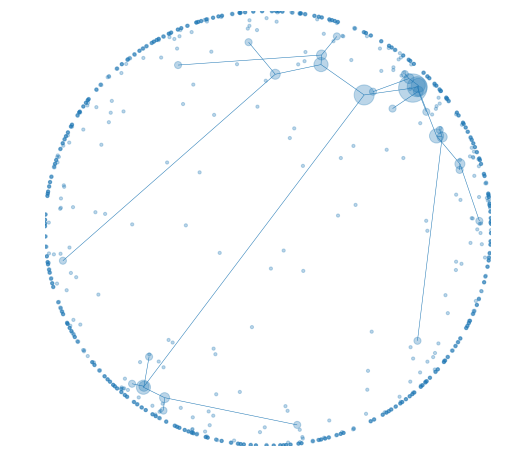

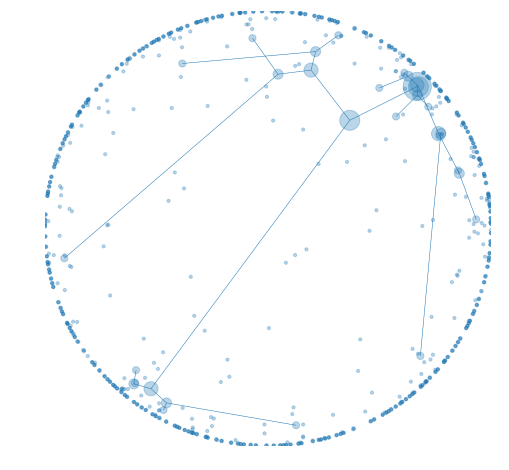

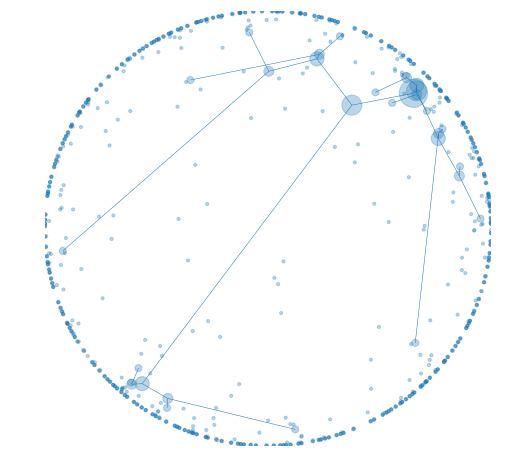

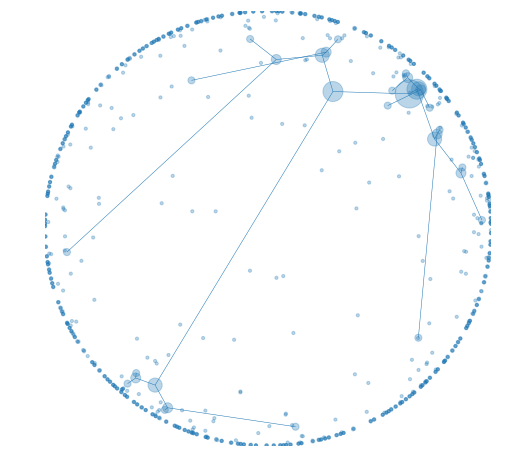

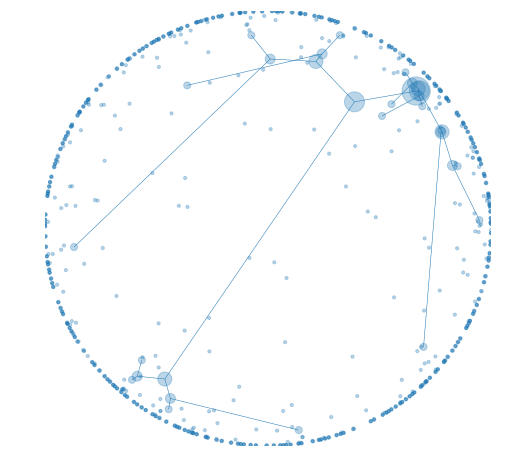

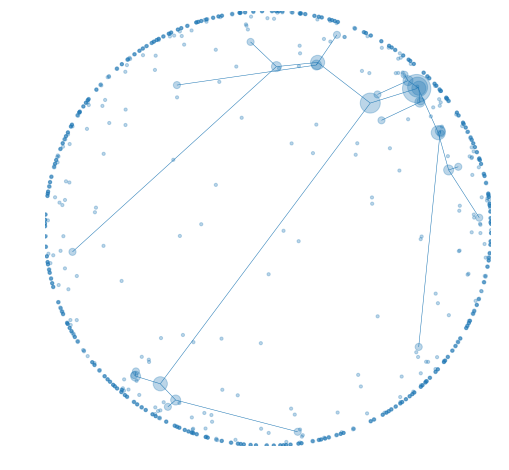

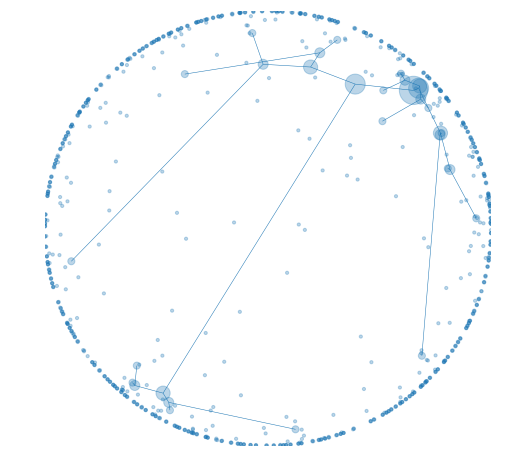

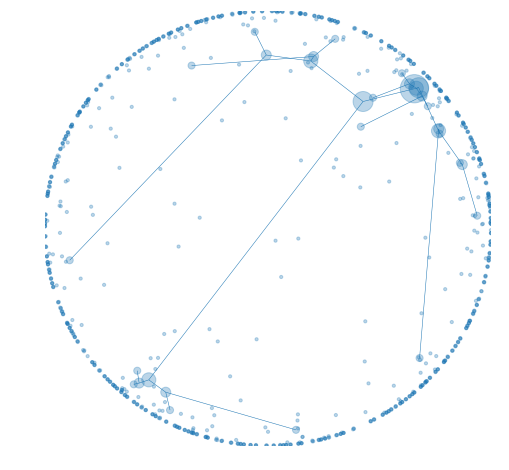

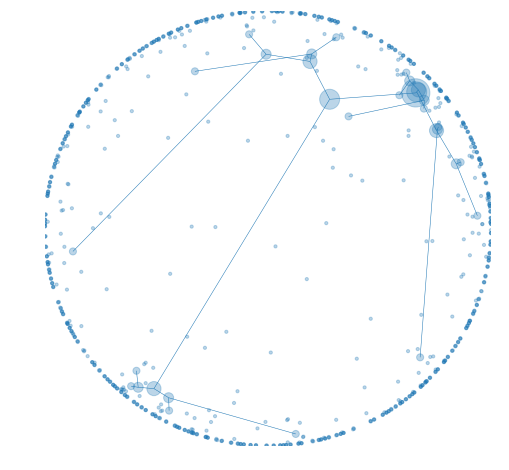

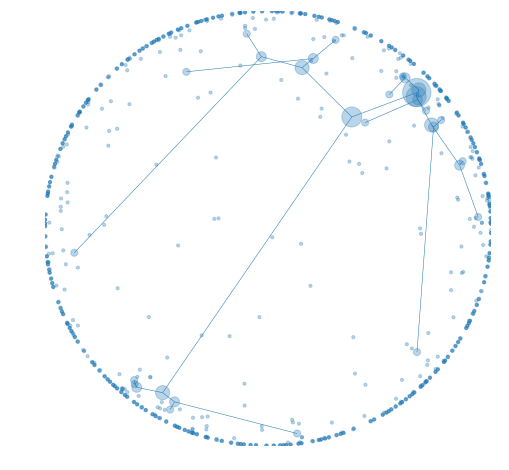

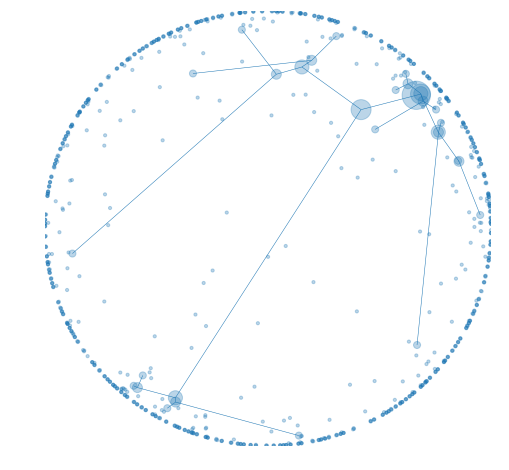

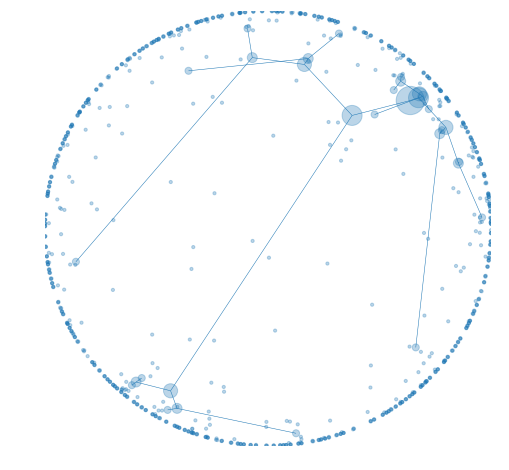

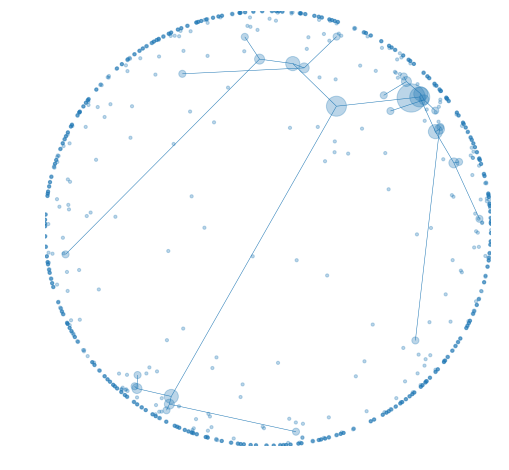

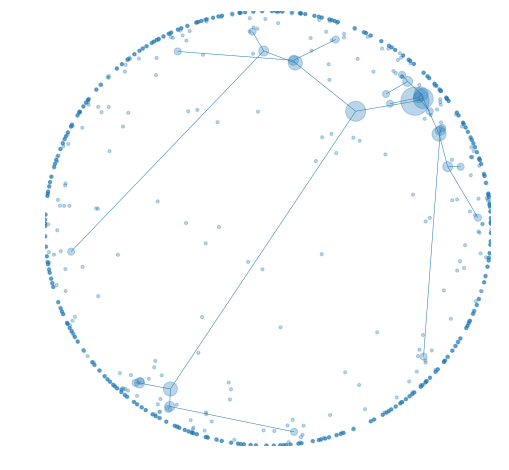

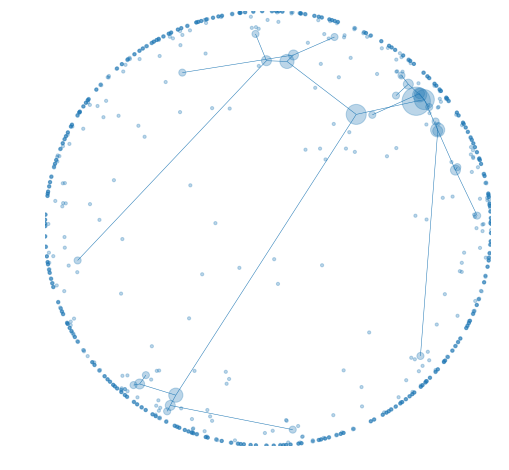

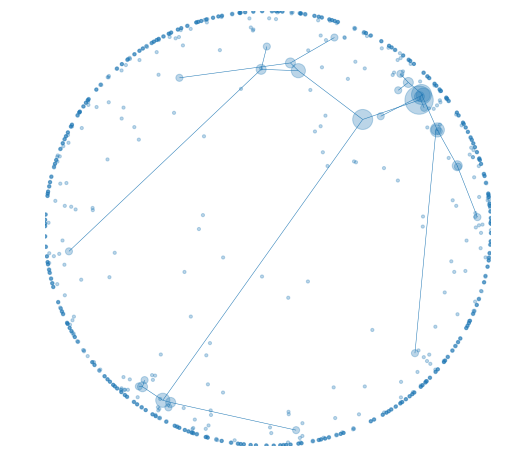

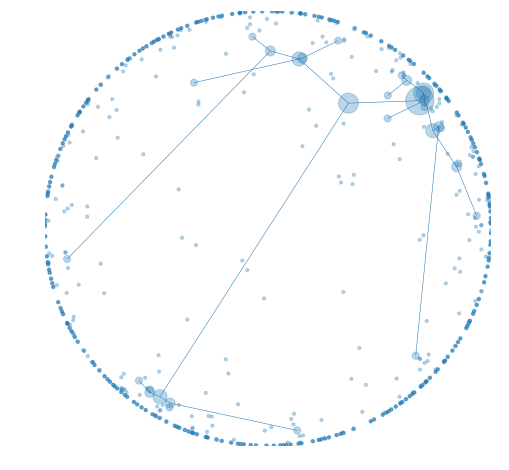

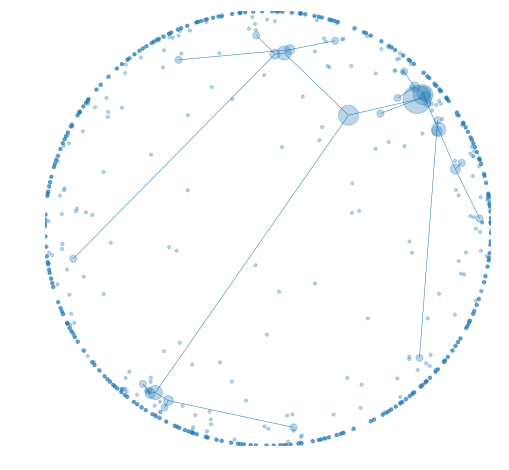

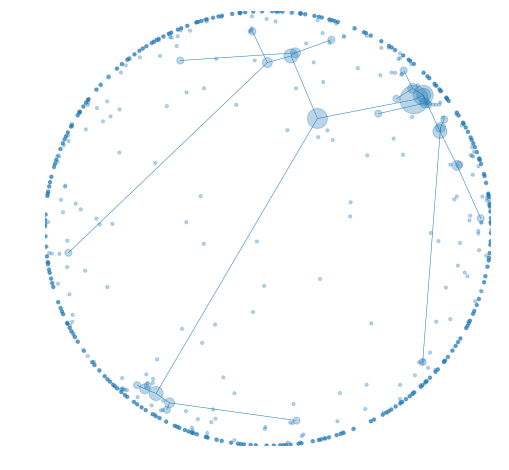

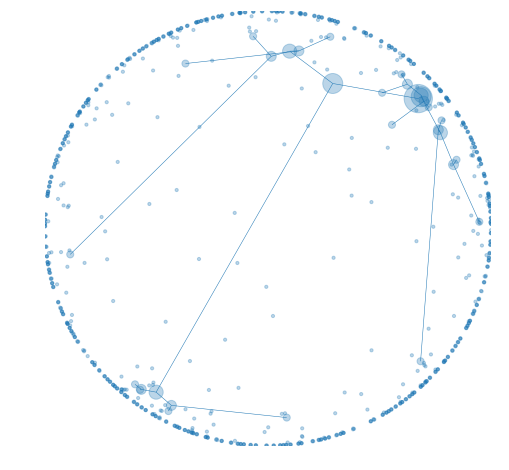

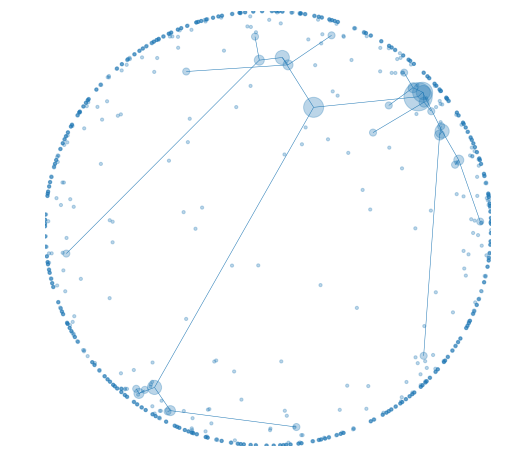

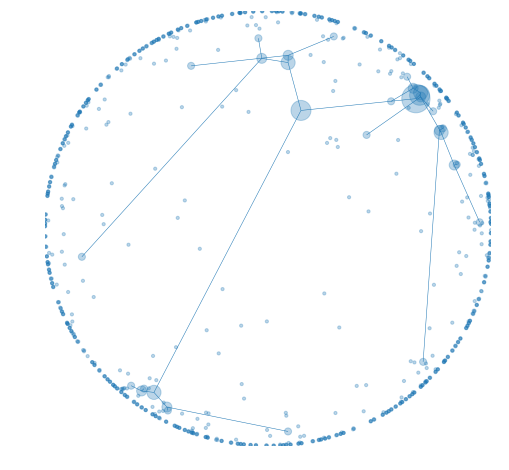

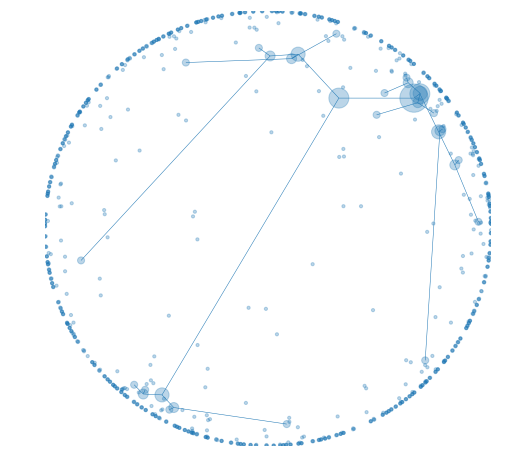

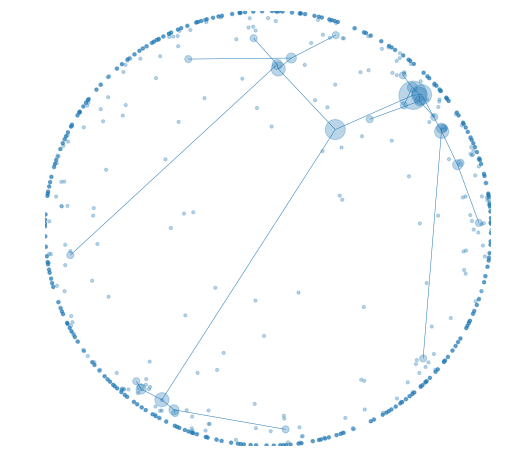

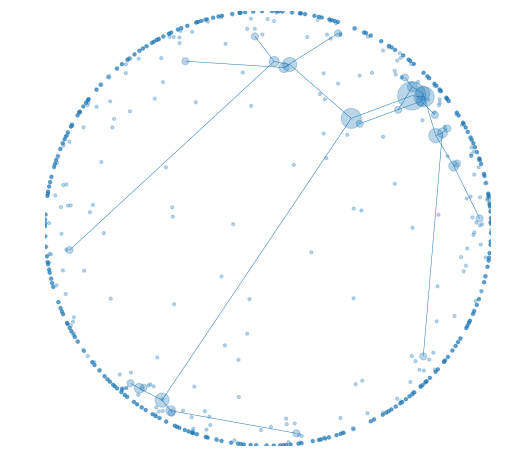

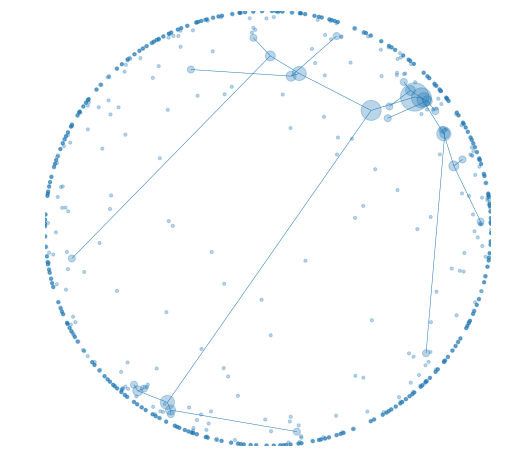

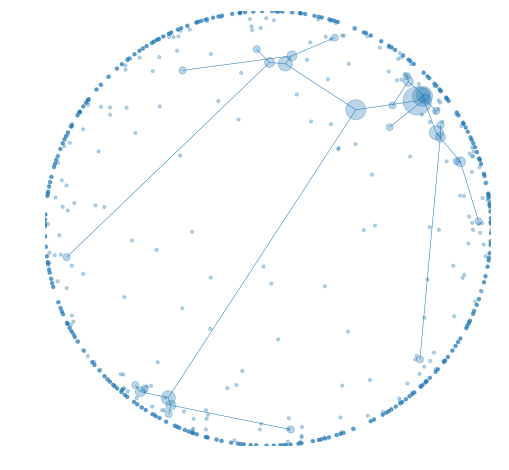

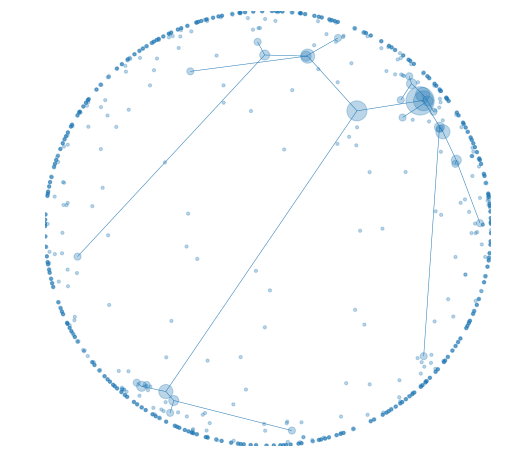

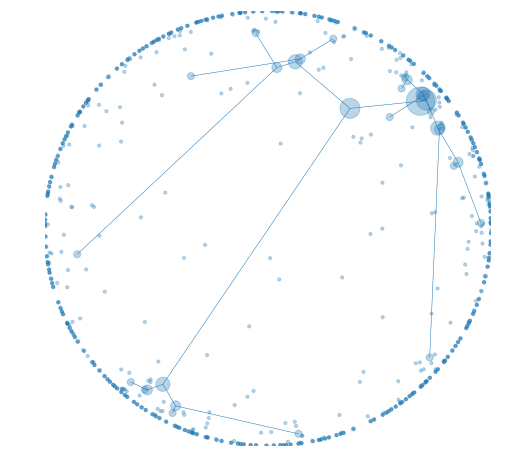

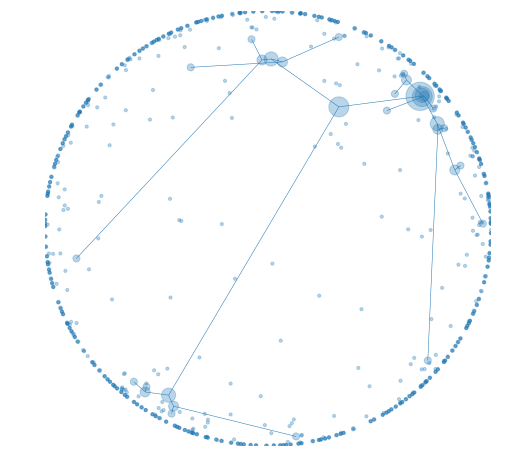

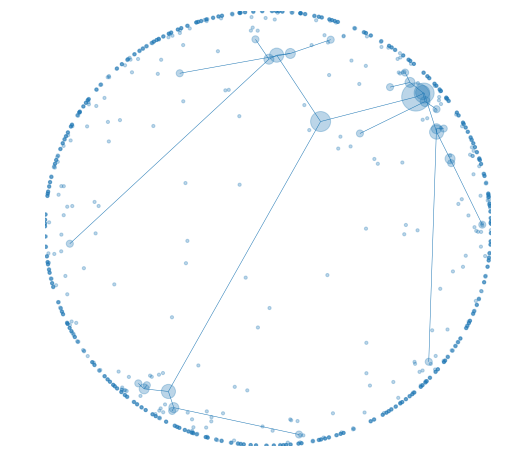

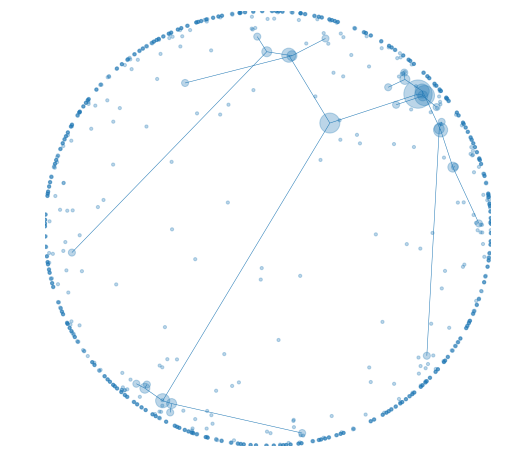

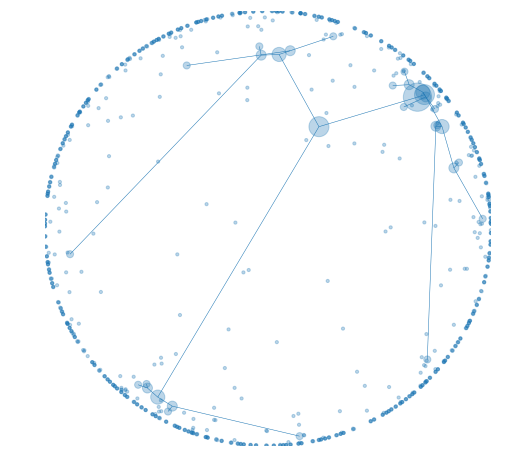

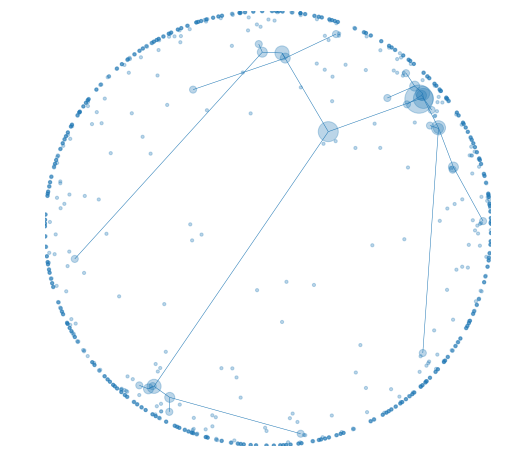

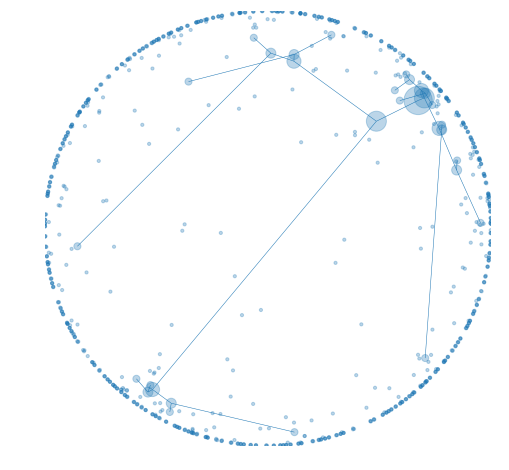

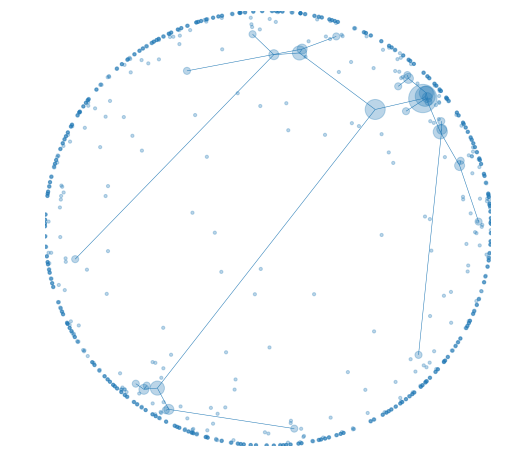

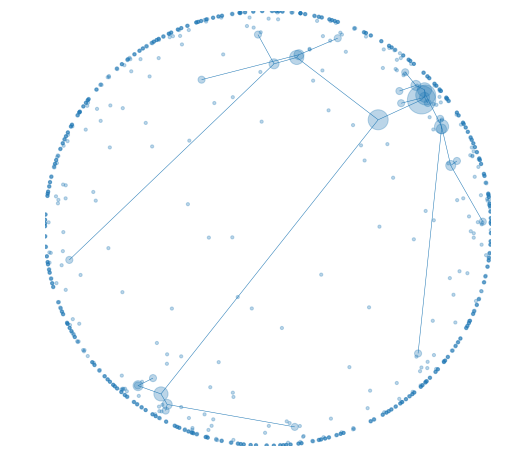

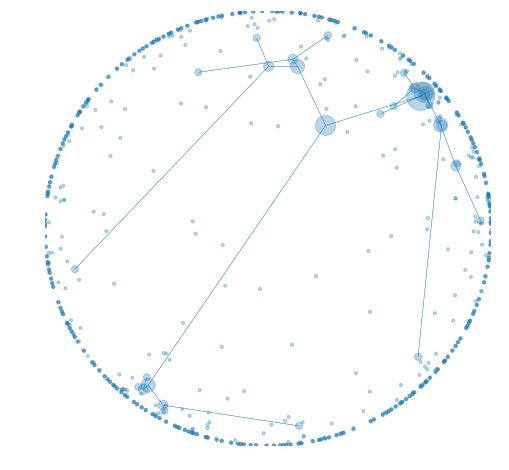

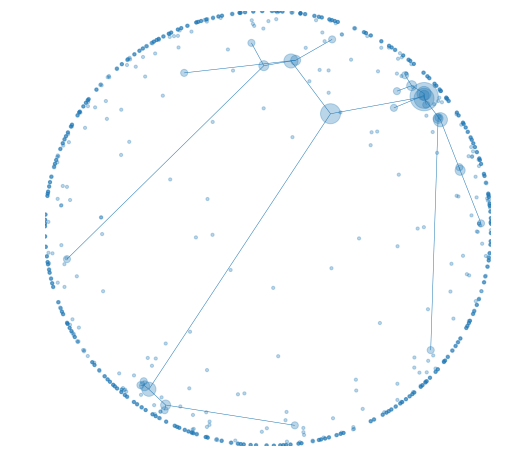

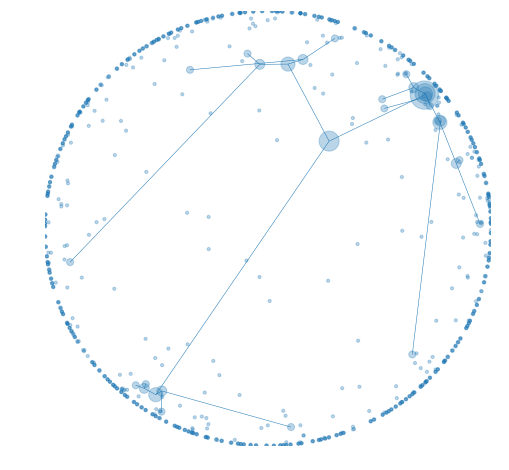

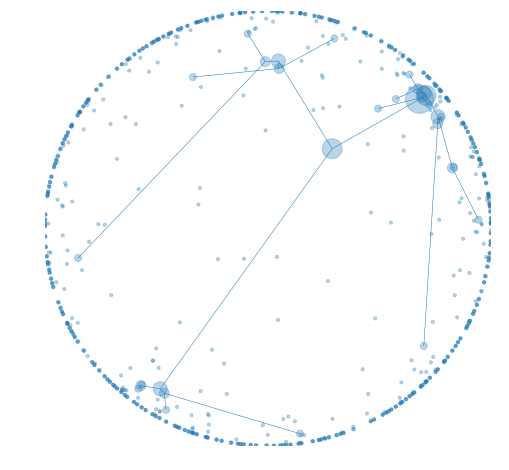

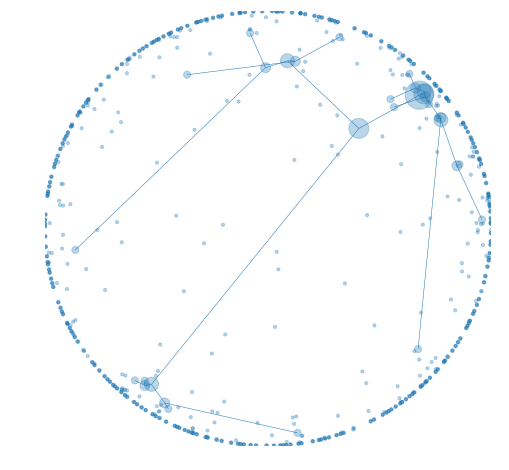

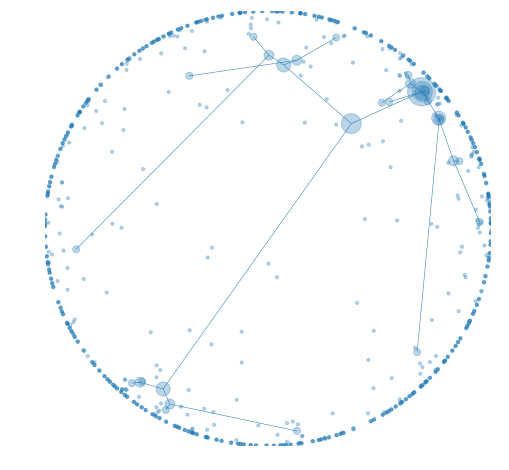

In [115]:
for i in range(9, maxn, 10):
    fig = plot(model, i, './wordnet/binaryTree.tsv', False, False, True)
    fig.savefig(f'./anim/{i}.png')

In [121]:
import os
import imageio
images = []
root = './anim/'
paths = []
for file in os.listdir(root):
    path = os.path.join(root, file)
    try:
        paths.append((path, int(file.split('.')[0])))
    except:
        pass
paths.sort(key=lambda x: x[1])
for path, i in paths:
    images.append(imageio.imread(path))
imageio.mimsave('./anim/movie.gif', images, duration=0.2)